In [ ]:
import numpy as np

PATH = "../data_fixed/stock_data.npy"
arr = np.load(PATH, allow_pickle=True)

if arr.ndim == 3:    # (N, T, D)
    N, T, D = arr.shape
elif arr.ndim == 2:  # (T, D)
    N, (T, D) = 1, arr.shape
else:                # (T,)
    N, T, D = 1, arr.shape[0], 1

train = int(0.6 * T)
val   = int(0.2 * T)
test  = T - train - val

print(f"Shape: {arr.shape} -> N={N}, T={T}, D={D}")
print(f"Split (temporal 60/20/20): train={train}, val={val}, test={test}")

Shape: (1, 3685, 6) -> N=1, T=3685, D=6
Split (temporal 60/20/20): train=2211, val=737, test=737


.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


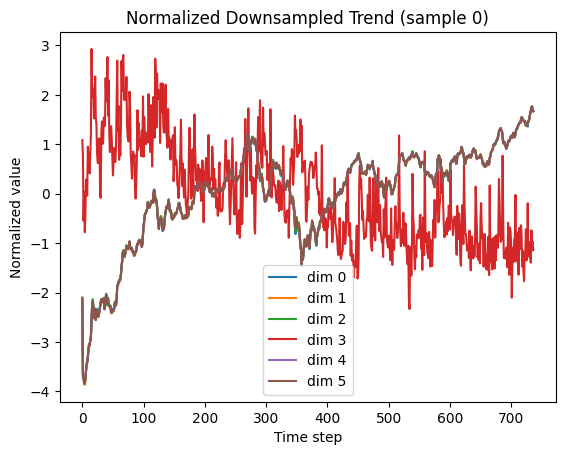

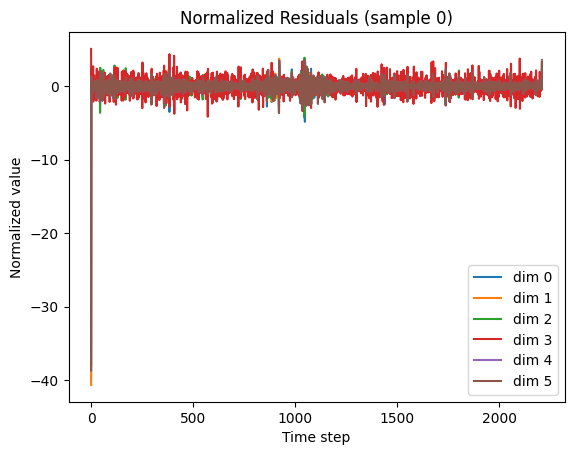

PAYAM
(1, 737, 6)
737 6 0
payam
PAYAM
PAYAM
(1, 2211, 6)
2211 6 0
payam
PAYAM
hello world, version 2
Epoch 1/1500 - Avg Loss: 1.076966
Epoch 2/1500 - Avg Loss: 0.460670
Epoch 3/1500 - Avg Loss: 0.347099
Epoch 4/1500 - Avg Loss: 0.287266
Epoch 5/1500 - Avg Loss: 0.267162
Epoch 6/1500 - Avg Loss: 0.224394
Epoch 7/1500 - Avg Loss: 0.217913
Epoch 8/1500 - Avg Loss: 0.196499
Epoch 9/1500 - Avg Loss: 0.180051
Epoch 10/1500 - Avg Loss: 0.183849
Epoch 11/1500 - Avg Loss: 0.181057
Epoch 12/1500 - Avg Loss: 0.156335
Epoch 13/1500 - Avg Loss: 0.149888
Epoch 14/1500 - Avg Loss: 0.157450
Epoch 15/1500 - Avg Loss: 0.141983
Epoch 16/1500 - Avg Loss: 0.151749
Epoch 17/1500 - Avg Loss: 0.137977
Epoch 18/1500 - Avg Loss: 0.157320
Epoch 19/1500 - Avg Loss: 0.138271
Epoch 20/1500 - Avg Loss: 0.136814
Epoch 21/1500 - Avg Loss: 0.129756
Epoch 22/1500 - Avg Loss: 0.120043
Epoch 23/1500 - Avg Loss: 0.119728
Epoch 24/1500 - Avg Loss: 0.129930
Epoch 25/1500 - Avg Loss: 0.127590
Epoch 26/1500 - Avg Loss: 0.12643

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from run_training import run_training
from helper import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

save_npy_path = "../data_fixed_60_ablation/stock_data_train.npy"

trend_model, residual_model = run_training(
    data_npy=save_npy_path,
    ma_window_size=3,       # moving average window for trend decomposition
    window_size=10,         # model window size W
    time_emb_dim=128,
    base_channels=64,
    n_res_blocks=8,
    timesteps=2000,
    s=0.007,
    batch_size=32,
    epochs=1500,
    lr=1e-3,
    device=device,
    show_detail=False,
    sample_interval=5
)

In [4]:
meta = {
    "in_channels": 6,
    "window_size": 10,
    "time_emb_dim": 128,
    "base_channels": 64,
    "n_res_blocks": 8,
    "timesteps": 2000,
    "s": 0.007,
}

save_diffpm(residual_model, trend_model, meta, "Ablation/diffpm_stock_60_1500_w10.pt")

[save_diffpm] Saved checkpoint → Ablation/diffpm_stock_60_1500_w10.pt


In [ ]:
# === Imports & Config ===
import os, glob, math, time, json, random
from pathlib import Path
from typing import Tuple, List, Optional, Dict

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

# ---- Repro & device ----
SEEDS = [0, 1, 2, 3, 4]         # ≥5 seeds, used for both dataloading shuffles & model init
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# ---- Data (stock, 60/20/20 split prepared earlier) ----
REAL_DIR = Path("../data_fixed_60_ablation")
REAL_TRAIN = REAL_DIR / "stock_data_train.npy"
REAL_VAL   = REAL_DIR / "stock_data_val.npy"
REAL_TEST  = REAL_DIR / "stock_data_test.npy"

# ---- Synthetic (generated from the 60% real only) ----
SYN_DIR = Path("../Ablation")
SYN_GLOB = "diffpm_stock_60_1500_*.npy"  # 10 files: ..._42.npy, ..._43.npy, ...

# ---- Forecasting task ----
IN_LEN  = 256     # context length
OUT_LEN = 64      # horizon
STRIDE  = 1       # sliding window stride

# ---- Training ----
BATCH_SIZE   = 64
EPOCHS       = 10
LR           = 1e-3
WEIGHT_DECAY = 0.05
PATIENCE     = 6    # early stopping
NUM_WORKERS  = 4

# ---- Model (data-hungry Transformer) ----
D_MODEL    = 512
N_HEADS    = 8
N_LAYERS   = 6
FFN_EXPAND = 4
DROPOUT    = 0.2

# ---- Synthetic ratios for sweep (k ∈ {1×, 2×, 5×, 10×}) ----
K_RATIOS = [1, 2, 5, 10]


Device: cuda


In [23]:
# === Utilities ===

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

class PerChannelStandardizer:
    """
    Fit only on REAL-TRAIN. Apply the same transform to synthetic/val/test.
    """
    def __init__(self):
        self.mean = None
        self.std  = None

    def fit(self, arr: np.ndarray):
        # arr: (N, T, D)
        self.mean = arr.mean(axis=(0, 1)).astype(np.float32)  # (D,)
        std = arr.std(axis=(0, 1)).astype(np.float32)
        self.std  = np.where(std < 1e-8, 1.0, std)

    def transform(self, arr: np.ndarray) -> np.ndarray:
        # arr: (..., D)
        return (arr - self.mean) / self.std

    def inverse_transform(self, arr: np.ndarray) -> np.ndarray:
        return arr * self.std + self.mean

def load_real_splits() -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    x_tr = np.load(REAL_TRAIN)  # (N, T_tr, D)
    x_va = np.load(REAL_VAL)    # (N, T_va, D)
    x_te = np.load(REAL_TEST)   # (N, T_te, D)
    return x_tr.astype(np.float32), x_va.astype(np.float32), x_te.astype(np.float32)

def load_synthetic_stack(truncate_T: int) -> np.ndarray:
    """
    Load all synthetic .npy files, stack to (K, T, D), and truncate to training length (no look-ahead).
    """
    files = sorted(SYN_DIR.glob(SYN_GLOB))
    if not files:
        raise FileNotFoundError(f"No synthetic files matching {SYN_GLOB} in {SYN_DIR}")
    syn_list = []
    for f in files:
        arr = np.load(f).astype(np.float32)  # (T, D)
        if arr.ndim != 2:
            raise ValueError(f"Synthetic file {f.name} must be (T, D); got {arr.shape}")
        syn_list.append(arr[:truncate_T])    # truncate to T_train only
    syn = np.stack(syn_list, axis=0)         # (K, T_train, D)
    return syn


In [24]:
# === Sliding-window dataset ===

class WindowDataset(Dataset):
    """
    Builds (X, Y) windows from arrays shaped (N, T, D).
    X: [IN_LEN], Y: next [OUT_LEN]; strictly causal.
    """
    def __init__(self, arrays: List[np.ndarray], in_len: int, out_len: int, stride: int = 1):
        self.in_len = in_len
        self.out_len = out_len
        self.samples = []  # list of (array_idx, start_idx)
        self.arrays = arrays

        for ai, arr in enumerate(arrays):
            N, T, D = arr.shape
            for n in range(N):
                # valid start indices so that start+in_len+out_len <= T
                max_start = T - (in_len + out_len)
                if max_start < 0:  # too short
                    continue
                for s in range(0, max_start + 1, stride):
                    self.samples.append((ai, n, s))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        ai, n, s = self.samples[idx]
        arr = self.arrays[ai][n]  # (T, D)
        x = arr[s : s + self.in_len]              # (IN_LEN, D)
        y = arr[s + self.in_len : s + self.in_len + self.out_len]  # (OUT_LEN, D)
        return torch.from_numpy(x), torch.from_numpy(y)

def build_loader(arrays: List[np.ndarray], batch_size: int, shuffle: bool, num_workers: int) -> DataLoader:
    ds = WindowDataset(arrays, IN_LEN, OUT_LEN, STRIDE)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, drop_last=False)


In [25]:
# === Transformer forecaster ===

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe)  # (max_len, d_model)

    def forward(self, x):
        # x: (S, B, D)
        s = x.size(0)
        x = x + self.pe[:s].unsqueeze(1)
        return self.dropout(x)

class Seq2SeqTransformer(nn.Module):
    """
    Encoder: IN_LEN x D -> d_model
    Decoder: OUT_LEN query tokens to predict next D per step
    """
    def __init__(self, d_in: int, d_model: int, n_heads: int, n_layers: int, ffn_expand: int, dropout: float, out_len: int):
        super().__init__()
        self.out_len = out_len

        self.in_proj  = nn.Linear(d_in, d_model)
        self.pos_enc  = PositionalEncoding(d_model, dropout=dropout)

        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=n_heads,
            num_encoder_layers=n_layers,
            num_decoder_layers=n_layers,
            dim_feedforward=d_model * ffn_expand,
            dropout=dropout,
            batch_first=False,  # we use (S, B, E)
        )

        # decoder query embeddings (OUT_LEN, d_model)
        self.dec_queries = nn.Parameter(torch.randn(out_len, d_model) * 0.02)
        self.out_proj    = nn.Linear(d_model, d_in)

    def _gen_causal_mask(self, size: int, device) -> torch.Tensor:
        # (size, size) mask with -inf for future positions
        mask = torch.full((size, size), float('-inf'), device=device)
        mask = torch.triu(mask, diagonal=1)
        return mask

    def forward(self, x_in: torch.Tensor) -> torch.Tensor:
        """
        x_in: (B, IN_LEN, D)
        returns: (B, OUT_LEN, D)
        """
        B, S, D = x_in.shape

        # encoder
        enc = self.in_proj(x_in)               # (B, S, d_model)
        enc = enc.transpose(0, 1)              # (S, B, d_model)
        enc = self.pos_enc(enc)                # +pos

        # decoder: learned queries (no teacher forcing)
        dec = self.dec_queries.unsqueeze(1).expand(-1, B, -1)  # (OUT_LEN, B, d_model)
        dec = self.pos_enc(dec)

        tgt_mask = self._gen_causal_mask(self.out_len, device=enc.device)

        hs = self.transformer(
            src=enc,
            tgt=dec,
            tgt_mask=tgt_mask,
            memory_key_padding_mask=None,
        )  # (OUT_LEN, B, d_model)

        hs = hs.transpose(0, 1)                # (B, OUT_LEN, d_model)
        y  = self.out_proj(hs)                 # (B, OUT_LEN, D)
        return y


In [26]:
# === Train / eval ===

def metrics_mse_mae(y_true: torch.Tensor, y_pred: torch.Tensor) -> Tuple[float, float]:
    mse = torch.mean((y_true - y_pred) ** 2).item()
    mae = torch.mean(torch.abs(y_true - y_pred)).item()
    return mse, mae

def evaluate(model: nn.Module, loader: DataLoader) -> Tuple[float, float]:
    model.eval()
    mse_sum, mae_sum, n = 0.0, 0.0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE).float()
            yb = yb.to(DEVICE).float()
            yp = model(xb)
            mse, mae = metrics_mse_mae(yb, yp)
            bs = xb.size(0)
            mse_sum += mse * bs
            mae_sum += mae * bs
            n += bs
    return mse_sum / max(n,1), mae_sum / max(n,1)

def train_once(
    seed: int,
    train_loader: DataLoader,
    val_loader: DataLoader,
    d_in: int,
) -> Dict[str, float]:
    set_seed(seed)

    model = Seq2SeqTransformer(
        d_in=d_in,
        d_model=D_MODEL,
        n_heads=N_HEADS,
        n_layers=N_LAYERS,
        ffn_expand=FFN_EXPAND,
        dropout=DROPOUT,
        out_len=OUT_LEN,
    ).to(DEVICE)

    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    best_val = float("inf")
    best_state = None
    bad = 0

    for ep in range(1, EPOCHS + 1):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(DEVICE).float()
            yb = yb.to(DEVICE).float()
            yp = model(xb)
            loss = nn.functional.mse_loss(yp, yb)  # MSE objective
            opt.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

        val_mse, val_mae = evaluate(model, val_loader)
        print(f"loss of epoch {ep}, {loss}")
        if val_mse < best_val - 1e-6:
            best_val = val_mse
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1

        # print(f"Seed {seed} | Epoch {ep:02d} | Val MSE {val_mse:.4f} | MAE {val_mae:.4f}")
        if bad >= PATIENCE:
            break

    # restore
    if best_state is not None:
        model.load_state_dict(best_state)

    return {"model": model}


In [27]:
# === Load data, fit scaler (real-train only), transform splits & synthetic ===

x_tr_real, x_va_real, x_te_real = load_real_splits()
print("Real splits:", x_tr_real.shape, x_va_real.shape, x_te_real.shape)

N_tr, T_tr, D = x_tr_real.shape

# Synthetic: load and truncate to T_tr (no look-ahead)
x_syn_full = load_synthetic_stack(truncate_T=T_tr)  # (K, T_tr, D)
print("Synthetic (K, T_tr, D):", x_syn_full.shape)

# Fit scaler on REAL-TRAIN only, then transform all
scaler = PerChannelStandardizer()
scaler.fit(x_tr_real)  # <-- hygiene: fit only on real-train
x_tr_real_z = scaler.transform(x_tr_real)
x_va_real_z = scaler.transform(x_va_real)
x_te_real_z = scaler.transform(x_te_real)
x_syn_z     = scaler.transform(x_syn_full)   # (K, T_tr, D)


Real splits: (1, 2211, 6) (1, 737, 6) (1, 737, 6)
Synthetic (K, T_tr, D): (10, 2211, 6)


In [28]:
# === Build loaders ===

def make_real_only_loaders(seed: int):
    set_seed(seed)
    train_loader = build_loader([x_tr_real_z], batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
    val_loader   = build_loader([x_va_real_z], batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    test_loader  = build_loader([x_te_real_z], batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    return train_loader, val_loader, test_loader

def make_real_plus_synth_loaders(seed: int, k_ratio: int):
    """
    k_ratio = (#synthetic windows) / (#real train windows)
    We subsample synthetic windows to reach target ratio (seeded).
    """
    set_seed(seed)

    # Real loaders (val/test same as A)
    real_train_ds = WindowDataset([x_tr_real_z], IN_LEN, OUT_LEN, STRIDE)
    val_loader    = build_loader([x_va_real_z], BATCH_SIZE, False, NUM_WORKERS)
    test_loader   = build_loader([x_te_real_z], BATCH_SIZE, False, NUM_WORKERS)

    # Synthetic windows (pool from K synthetic series)
    syn_train_ds_full = WindowDataset([x_syn_z], IN_LEN, OUT_LEN, STRIDE)

    # Determine target count
    n_real = len(real_train_ds)
    n_target_syn = k_ratio * n_real

    # Subsample synthetic indices deterministically per seed
    all_idx = np.arange(len(syn_train_ds_full))
    if len(all_idx) == 0:
        raise ValueError("No synthetic windows available (check IN_LEN/OUT_LEN vs T_tr).")
    if n_target_syn >= len(all_idx):
        sel = all_idx
    else:
        rng = np.random.default_rng(seed)
        sel = rng.choice(all_idx, size=n_target_syn, replace=False)
    sel = set(sel)

    # Wrap a tiny proxy dataset that filters __getitem__ for selected indices
    class _SubsetDS(Dataset):
        def __init__(self, base, selected: set):
            self.base = base
            self.sel  = sorted(list(selected))
        def __len__(self): return len(self.sel)
        def __getitem__(self, i): return self.base[self.sel[i]]

    syn_subset = _SubsetDS(syn_train_ds_full, sel)

    # Concat real + synthetic by simple multi-loader dataset
    class _ConcatDS(Dataset):
        def __init__(self, a: Dataset, b: Dataset):
            self.a = a; self.b = b
        def __len__(self): return len(self.a) + len(self.b)
        def __getitem__(self, i):
            if i < len(self.a): return self.a[i]
            return self.b[i - len(self.a)]

    concat_train = _ConcatDS(real_train_ds, syn_subset)
    train_loader = DataLoader(concat_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=False)

    return train_loader, val_loader, test_loader


In [29]:
# === Run ablation across seeds ===

def run_eval(loaders_fn, *args):
    mses, maes = [], []
    for s in SEEDS:
        loaders = loaders_fn(s, *args) if len(args) else loaders_fn(s)
        train_loader, val_loader, test_loader = loaders

        # Train with identical hyperparams
        info = train_once(seed=s, train_loader=train_loader, val_loader=val_loader, d_in=D)
        model = info["model"]

        # Eval on identical REAL test set
        test_mse, test_mae = evaluate(model, test_loader)
        mses.append(test_mse); maes.append(test_mae)
    return np.array(mses), np.array(maes)

# A: Real-only
A_mse, A_mae = run_eval(make_real_only_loaders)
print(f"A (real-only)  Test MSE: {A_mse.mean():.4f} ± {A_mse.std():.4f} | MAE: {A_mae.mean():.4f} ± {A_mae.std():.4f}")

# B@k: Real + Synthetic (k ∈ K_RATIOS)
results = {}
for k in K_RATIOS:
    B_mse, B_mae = run_eval(make_real_plus_synth_loaders, k)
    gain_mse = (A_mse - B_mse)  # our "Gain" definition (Δ = A - B)
    gain_mae = (A_mae - B_mae)
    results[k] = {
        "mse": B_mse, "mae": B_mae,
        "gain_mse": gain_mse, "gain_mae": gain_mae
    }
    print(f"B@{k}x  Test MSE: {B_mse.mean():.4f} ± {B_mse.std():.4f} | "
          f"MAE: {B_mae.mean():.4f} ± {B_mae.std():.4f} | "
          f"Gain MSE: {gain_mse.mean():.4f} | Gain MAE: {gain_mae.mean():.4f}")


loss of epoch 1, 0.550055742263794
loss of epoch 2, 0.4328998327255249
loss of epoch 3, 0.42748817801475525
loss of epoch 4, 0.3846301734447479
loss of epoch 5, 0.4684145152568817
loss of epoch 6, 0.3987007141113281
loss of epoch 7, 0.4167138934135437
loss of epoch 8, 0.43138575553894043
loss of epoch 9, 0.4769900441169739
loss of epoch 10, 0.45655399560928345
loss of epoch 1, 0.39959728717803955
loss of epoch 2, 0.4284090995788574
loss of epoch 3, 0.5230414271354675
loss of epoch 4, 0.5201534628868103
loss of epoch 5, 0.49322834610939026
loss of epoch 6, 0.44781410694122314
loss of epoch 7, 0.34259626269340515
loss of epoch 8, 0.34343859553337097
loss of epoch 9, 0.3341658115386963
loss of epoch 10, 0.3824748396873474
loss of epoch 1, 0.4127703905105591
loss of epoch 2, 0.41118472814559937
loss of epoch 3, 0.416789174079895
loss of epoch 4, 0.4816221296787262
loss of epoch 5, 0.5086275339126587
loss of epoch 6, 0.5113977789878845
loss of epoch 7, 0.49440357089042664
loss of epoch 8, 0

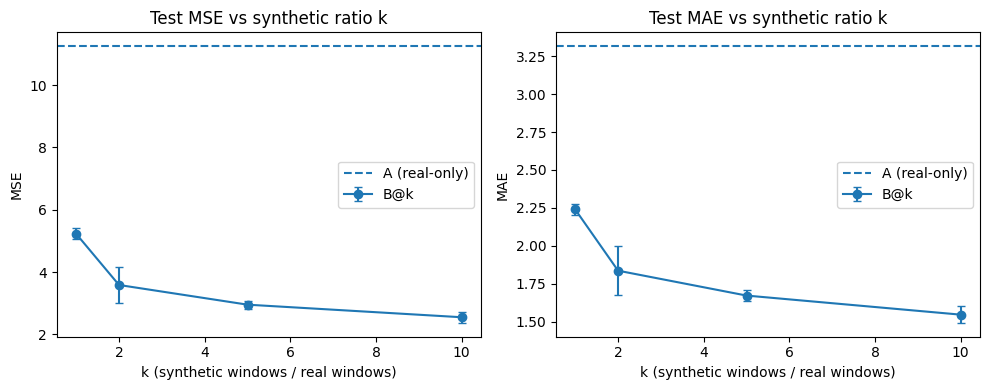

In [30]:
# === Plot MSE/MAE vs k ===

ks = []
mse_means, mse_stds = [], []
mae_means, mae_stds = [], []

for k in K_RATIOS:
    ks.append(k)
    mse_means.append(results[k]["mse"].mean())
    mse_stds.append(results[k]["mse"].std())
    mae_means.append(results[k]["mae"].mean())
    mae_stds.append(results[k]["mae"].std())

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.errorbar(ks, mse_means, yerr=mse_stds, marker='o', capsize=3, label="B@k")
plt.axhline(A_mse.mean(), linestyle='--', label="A (real-only)")
plt.title("Test MSE vs synthetic ratio k")
plt.xlabel("k (synthetic windows / real windows)")
plt.ylabel("MSE")
plt.legend()

plt.subplot(1,2,2)
plt.errorbar(ks, mae_means, yerr=mae_stds, marker='o', capsize=3, label="B@k")
plt.axhline(A_mae.mean(), linestyle='--', label="A (real-only)")
plt.title("Test MAE vs synthetic ratio k")
plt.xlabel("k (synthetic windows / real windows)")
plt.ylabel("MAE")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# === Dedup/Similarity check ===
# L2 distance between (standardized) REAL-TEST series and SYN-TRAIN series.

def flatten_series(arr: np.ndarray, length: int) -> np.ndarray:
    """
    arr: (N, T, D)
    flatten first 'length' steps to (N, length*D)
    """
    N, T, D = arr.shape
    L = min(T, length)
    flat = arr[:, :L, :].reshape(N, -1)
    return flat

# Use equal length = min(T_train, T_test)
eq_len = min(x_tr_real_z.shape[1], x_te_real_z.shape[1])

# Training synthetic series matrix (K, eq_len*D)
syn_flat = flatten_series(x_syn_z, eq_len)      # (K, L*D)
# Test real series matrix (N_te, eq_len*D)
test_flat = flatten_series(x_te_real_z, eq_len) # (N_te, L*D)

# Compute NN distances Test -> SyntheticTrain
dists = []
for v in test_flat:
    diffs = syn_flat - v[None, :]
    l2 = np.sqrt(np.sum(diffs**2, axis=1))
    dists.append(l2.min())
dists = np.array(dists)

p5, p50, p95 = np.percentile(dists, [5, 50, 95])
print(f"Nearest-neighbor L2 distance (Test→SyntheticTrain), standardized space | "
      f"p5: {p5:.3f} | p50: {p50:.3f} | p95: {p95:.3f}")
